## Contradictory claims analysis notebook
### Authors: Dan Sosa and Malavika Suresh 

Purpose: This notebook is intended for running the trained contradictory-claims detection model and analyzing the results on CORD-19 extracted claims. 

In [1]:
# Imports

# To install contradictory_claims, please ensure that the package is pip installed in development from source.
# 
# $ cd drug-lit-conradictory-claims
# $ pip install -e .

import os

import contradictory_claims as cc
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from transformers import AutoTokenizer

In [2]:
# Load trained model (ASSUMES TRAINED ALREADY!)
transformer_dir = "/Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/output/transformer/biomed_roberta/24-7-2020_16-23"
pickle_file = os.path.join(transformer_dir, 'sigmoid.pickle')
model = cc.models.train_model.load_model(pickle_file, transformer_dir)

All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at /Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/output/transformer/biomed_roberta/24-7-2020_16-23.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [3]:
# Load data for predicting
# TODO: Repackage this logic into a function?

eval_data_dir = "/Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/input"
eval_data_path = os.path.join(eval_data_dir, "roam_annotations_DEV_set.csv")
#eval_data = pd.read_excel(eval_data_path,sheet_name='drug_individual_claims_similari')
eval_data = pd.read_csv(eval_data_path)
eval_data = eval_data.dropna().reset_index(drop=True)

In [4]:
def splitter(in_str, index):
    text1 = in_str.rstrip().split("\n\n")[index]
    return text1

eval_data["text1"] = eval_data.text.transform(lambda x: splitter(x, 1))
eval_data["text2"] = eval_data.text.transform(lambda x: splitter(x, 3))
eval_data["annotation"] = eval_data.tags.transform(lambda x: x.lower())
# TO DO: Don't forget about the STRICTs!

In [5]:
import re

def simplify_tags(in_str):
    
    if in_str in ["ENTAILMENT", "CONTRADICTION", "NEUTRAL"]:
        return in_str
    elif in_str == "STRICT_ENTAILMENT":
        return "ENTAILMENT"
    elif in_str == "STRICT_CONTRADICTION":
        return "CONTRADICTION"
    elif re.compile("QUESTION|DUPLICATE").match(in_str):
        return "N/A"
    else:
        return None
    
eval_data["simple_tags"] = eval_data.apply(lambda row: simplify_tags(row["tags"]), axis = 1)
#eval_data[eval_data.tags.str.contains("DUPLICATE")]



In [58]:
# Do some polarity detection stuff
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('vader_lexicon')

def polarity_tb_score(text: str) -> float:
    # pip install textblob
    return TextBlob(text).sentiment.polarity

def polarity_v_score(text: str) -> float:
    vader = SentimentIntensityAnalyzer()
    return vader.polarity_scores(text)['compound']


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dnsosa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [59]:
eval_data["vader_pol_1"] = eval_data.apply(lambda row : polarity_v_score(row['text1']), axis = 1)
eval_data["vader_pol_2"] = eval_data.apply(lambda row : polarity_v_score(row['text2']), axis = 1)
eval_data["tb_pol_1"] = eval_data.apply(lambda row : polarity_tb_score(row['text1']), axis = 1)
eval_data["tb_pol_2"] = eval_data.apply(lambda row : polarity_tb_score(row['text2']), axis = 1)

In [60]:
def polarity_call(score1: float, score2: float) -> str:
    if score1 * score2 > 0:
        return "ENTAILMENT"
    elif score1 * score2 < 0:
        return "CONTRADICTION"
    else:
        return "NEUTRAL"

eval_data["vader_call"] = eval_data.apply(lambda row: polarity_call(row['vader_pol_1'], row['vader_pol_2']), axis = 1)
eval_data["tb_call"] = eval_data.apply(lambda row: polarity_call(row['tb_pol_1'], row['tb_pol_2']), axis = 1)


In [61]:
from fse.models.average import FAST_VERSION, MAX_WORDS_IN_BATCH
from fse.models import uSIF

import gensim.downloader as api
from fse import SplitIndexedList

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

import logging
logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)

glove = api.load("glove-wiki-gigaword-300")

sentences = list(mancon_data.text_a.values)
print(len(mancon_data.text_a.values))
sentences.extend(list(mancon_data.text_b.values))
#s = IndexedList(sentences*8)
s = SplitIndexedList(sentences)
print(len(s))
# NOTE, MANY repeats

print(MAX_WORDS_IN_BATCH)
print(FAST_VERSION) #uh oh...

model = uSIF(glove, workers=2, lang_freq="en")
model.train(s)

sent_sims = []
for i in range(len(mancon_data.text_a.values)):
    sim = model.sv.similarity(i, i+len(mancon_data.text_a.values))
    sent_sims.append(sim)
    
mancon_data["uSIF_sims"] = sent_sims
mancon_data["uSIF_sims"] = mancon_data["uSIF_sims"].abs()

,Unnamed: 0,docnum,tags,source,text,row_id,paper1_cord_uid,paper2_cord_uid,text1,text2,...,BioBERT_Prediction_ent,BioBERT_Prediction_neu,label,BioBERT_Prediction_class,vader_pol_1,vader_pol_2,tb_pol_1,tb_pol_2,vader_call,tb_call
0,128,128,CONTRADICTION,Demo-Annotations_43573ac3-R1,Claim1:\n\nsecondary clinical outcomes were al...,392,zhfrgaxf,2txzi7kb,secondary clinical outcomes were also consider...,three studies reported no significant differen...,...,0.000031,0.000139,contradiction,contradiction,-0.2023,-0.3612,0.060000,-0.187500,ENTAILMENT,CONTRADICTION
1,605,605,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nthe clinical use of tocilizumab can...,971,nqprluto,e5hi63rm,the clinical use of tocilizumab can be referre...,the mortality rate over a 30-days observation ...,...,0.000485,0.998734,neutral,neutral,0.3182,0.4019,0.000000,0.000000,ENTAILMENT,NEUTRAL
2,58,58,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\ncandidate drugs for post-exposure p...,513,n0mz098o,k50qvr4w,candidate drugs for post-exposure prophylaxis ...,-there is the necessity to quickly find therap...,...,0.982423,0.017534,neutral,entailment,-0.2500,0.7650,0.000000,0.311111,CONTRADICTION,NEUTRAL
3,577,577,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nonly in one patient was treatment s...,574,rqjzl8js,mzon01fd,"only in one patient was treatment stopped, due...","in fact, in portugal, hydroxychloroquine is ap...",...,0.659957,0.335435,neutral,entailment,-0.2263,0.4215,-0.062500,-0.125000,CONTRADICTION,ENTAILMENT
4,384,384,NEUTRAL,Demo-Annotations_43573ac3-R1,"Claim1:\n\namong the studied comorbidities, di...",377,7hnh85wy,be8eu3qi,"among the studied comorbidities, diabetes, pur...",further studies need to be conducted on a larg...,...,0.018491,0.981502,neutral,neutral,-0.3612,0.7184,0.214286,0.200000,CONTRADICTION,ENTAILMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,791,791,NEUTRAL,Demo-Annotations_43573ac3-R1,"Claim1:\n\nhowever, prospective clinical studi...",934,dk1rk908,rpmmadqc,"however, prospective clinical studies are requ...",this retrospective observational study is to o...,...,0.110376,0.859951,neutral,neutral,-0.1027,-0.1280,-0.025000,0.250000,ENTAILMENT,CONTRADICTION
496,632,632,ENTAILMENT,Demo-Annotations_43573ac3-R1,Claim1:\n\narabi and colleagues initiated a pl...,739,0nhgxoim,gh51ag2x,arabi and colleagues initiated a placebo-contr...,"in addition, considering that this unique trea...",...,0.006200,0.992145,entailment,neutral,0.7003,0.6369,0.400000,0.083750,ENTAILMENT,ENTAILMENT
497,636,636,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nall 50 (100%) patients received ant...,970,aidsz3st,n0mz098o,all 50 (100%) patients received antiviral ther...,besides preventive strategies against sars-cov...,...,0.037961,0.961965,neutral,neutral,-0.3818,-0.4939,0.250000,0.141224,ENTAILMENT,ENTAILMENT
498,583,583,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\ngiven its questionable efficacy in ...,510,hasoaa0k,aidsz3st,given its questionable efficacy in the treatme...,all 50 (100%) patients received antiviral ther...,...,0.006386,0.993426,neutral,neutral,-0.5106,-0.3818,-0.250000,0.250000,ENTAILMENT,CONTRADICTION


In [63]:
from fse.models.average import FAST_VERSION, MAX_WORDS_IN_BATCH
from fse.models import uSIF

import gensim.downloader as api
from fse import SplitIndexedList

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

import logging
logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)

glove = api.load("glove-wiki-gigaword-300")

sentences = list(eval_data.text1.values)
print(len(eval_data.text1.values))
sentences.extend(list(eval_data.text2.values))
#s = IndexedList(sentences*8)
s = SplitIndexedList(sentences)
print(len(s))
# NOTE, MANY repeats

print(MAX_WORDS_IN_BATCH)
print(FAST_VERSION) #uh oh...

model = uSIF(glove, workers=2, lang_freq="en")
model.train(s)

sent_sims = []
for i in range(len(eval_data.text1.values)):
    sim = model.sv.similarity(i, i+len(eval_data.text1.values))
    sent_sims.append(sim)
    
eval_data["uSIF_sims"] = sent_sims
eval_data["uSIF_sims"] = eval_data["uSIF_sims"].abs()

2020-11-01 21:32:38,332 : MainThread : INFO : loading projection weights from /Users/dnsosa/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz
2020-11-01 21:34:29,765 : MainThread : INFO : loaded (400000, 300) matrix from /Users/dnsosa/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz
2020-11-01 21:34:29,844 : MainThread : INFO : no frequency mode: using wordfreq for estimation of frequency for language: en


500
1000
10000
-1


2020-11-01 21:34:30,218 : MainThread : INFO : scanning all indexed sentences and their word counts
2020-11-01 21:34:30,223 : MainThread : INFO : finished scanning 1000 sentences with an average length of 36 and 36424 total words
2020-11-01 21:34:30,323 : MainThread : INFO : estimated memory for 1000 sentences with 300 dimensions and 400000 vocabulary: 460 MB (0 GB)
2020-11-01 21:34:30,329 : MainThread : INFO : initializing sentence vectors for 1000 sentences
2020-11-01 21:34:30,336 : MainThread : INFO : pre-computing uSIF weights for 400000 words
2020-11-01 21:34:31,424 : MainThread : INFO : begin training
2020-11-01 21:34:31,515 : MainThread : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-01 21:34:31,517 : MainThread : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-01 21:34:31,554 : MainThread : INFO : computing 5 principal components took 0s
2020-11-01 21:34:31,555 : MainThread : INFO : removing 5 principal components took 0s
2020-

In [66]:
def polarity_call_v2(score1: float, score2: float) -> str:
    if score1 * score2 > 0:
        return 1
    elif score1 * score2 < 0:
        return -1
    else:
        return 0

eval_data["vader_call_num"] = eval_data.apply(lambda row: polarity_call_v2(row['vader_pol_1'], row['vader_pol_2']), axis = 1)
eval_data["tb_call_num"] = eval_data.apply(lambda row: polarity_call_v2(row['tb_pol_1'], row['tb_pol_2']), axis = 1)

eval_data["vader_sim_score"] = eval_data.vader_call_num * eval_data.uSIF_sims
eval_data["tb_sim_score"] = eval_data.tb_call_num * eval_data.uSIF_sims


eval_data.head(3)

,Unnamed: 0,docnum,tags,source,text,row_id,paper1_cord_uid,paper2_cord_uid,text1,text2,...,vader_pol_2,tb_pol_1,tb_pol_2,vader_call,tb_call,uSIF_sims,vader_call_num,tb_call_num,vader_sim_score,tb_sim_score
0,128,128,CONTRADICTION,Demo-Annotations_43573ac3-R1,Claim1:\n\nsecondary clinical outcomes were al...,392,zhfrgaxf,2txzi7kb,secondary clinical outcomes were also consider...,three studies reported no significant differen...,...,-0.3612,0.06,-0.187500,ENTAILMENT,CONTRADICTION,0.387767,1,-1,0.387767,-0.387767
1,605,605,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nthe clinical use of tocilizumab can...,971,nqprluto,e5hi63rm,the clinical use of tocilizumab can be referre...,the mortality rate over a 30-days observation ...,...,0.4019,0.00,0.000000,ENTAILMENT,NEUTRAL,0.108610,1,0,0.108610,0.000000
2,58,58,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\ncandidate drugs for post-exposure p...,513,n0mz098o,k50qvr4w,candidate drugs for post-exposure prophylaxis ...,-there is the necessity to quickly find therap...,...,0.7650,0.00,0.311111,CONTRADICTION,NEUTRAL,0.131149,-1,0,-0.131149,0.000000


97
196


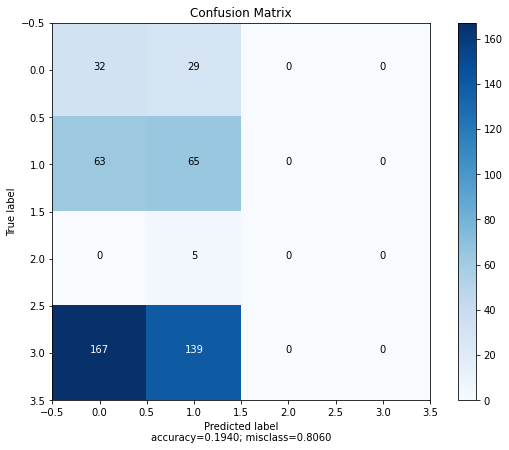

In [70]:
print(len(eval_data[eval_data.vader_call == eval_data.simple_tags]))
print(len(eval_data[eval_data.tb_call == eval_data.simple_tags]))

cm = confusion_matrix(eval_data.simple_tags, eval_data.vader_call)
#sklearn.metrics.confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import itertools

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

cmap = None
if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Confusion Matrix")
plt.colorbar()

target_names = None
if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

normalize = False
thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, f"{cm[i,j]:0.4f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")
plt.show()

# TO DO: WHERE ARE NEUTRALS??? FIX THE NAAMES OF THE LABELS 

In [31]:
# Fit model to data
MODEL = "allenai/biomed_roberta_base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
MAX_LEN = 512
method = 2 # what does this mean?

ls = []
for i in range(len(eval_data)):
    ls.append(str('[CLS]'+eval_data.loc[i,'text1']+'[SEP]'+eval_data.loc[i,'text2']))
    
test_example = cc.models.train_model.regular_encode(ls, tokenizer, maxlen=MAX_LEN)
predictions = model.predict(test_example)
if method==1:
    eval_data['BioBERT_Prediction'] = [p[0] for p in predictions]
if method==2:
    eval_data['BioBERT_Prediction_con'] = [p[2] for p in predictions]
    eval_data['BioBERT_Prediction_ent'] = [p[1] for p in predictions]
    eval_data['BioBERT_Prediction_neu'] = [p[0] for p in predictions]
    
# cc.models.make_prediction(model, data_to_evaluate, method)

In [10]:
predictions[:,0]

array([3.77541892e-02, 2.37536319e-02, 3.44767645e-02, 5.44285737e-02,
       3.95593233e-02, 1.06065627e-02, 1.16764627e-01, 5.89380693e-03,
       9.20911357e-02, 9.96827543e-01, 9.88629580e-01, 4.93962057e-02,
       9.73926008e-01, 7.60620296e-01, 7.23281920e-01, 8.73861492e-01,
       2.53235847e-01, 9.72916424e-01, 1.03668764e-01, 1.44971963e-02,
       2.91038364e-01, 9.12520349e-01, 1.88219901e-02, 8.14726651e-02,
       4.15736079e-01, 1.72990269e-03, 1.00266933e-02, 5.48873544e-01,
       9.02368784e-01, 1.15757226e-03, 2.83261295e-02, 5.82608692e-02,
       8.98916423e-01, 5.90599813e-02, 1.60535725e-04, 9.74803567e-01,
       3.48493992e-03, 1.33663951e-03, 7.78242573e-03, 3.75757739e-02,
       4.73361284e-01, 1.17610916e-01, 4.41008173e-02, 4.46949780e-05,
       1.34741098e-01, 3.58698564e-03, 4.78759371e-02, 5.05176298e-02,
       1.44713055e-02, 2.14075437e-03, 9.43107344e-03, 5.16039252e-01,
       3.31477016e-01, 9.70264155e-05, 4.79418576e-01, 3.16523225e-03,
      

In [11]:
predictions

array([[3.77541892e-02, 9.62054491e-01, 1.91276631e-04],
       [2.37536319e-02, 9.76153255e-01, 9.30413080e-05],
       [3.44767645e-02, 9.65356588e-01, 1.66652360e-04],
       [5.44285737e-02, 9.40603554e-01, 4.96783853e-03],
       [3.95593233e-02, 9.59143102e-01, 1.29760406e-03],
       [1.06065627e-02, 9.89370942e-01, 2.25261156e-05],
       [1.16764627e-01, 8.83223355e-01, 1.19876941e-05],
       [5.89380693e-03, 9.94092047e-01, 1.41136434e-05],
       [9.20911357e-02, 9.07853067e-01, 5.57062340e-05],
       [9.96827543e-01, 3.16608232e-03, 6.31158082e-06],
       [9.88629580e-01, 1.13570048e-02, 1.34885950e-05],
       [4.93962057e-02, 9.50447083e-01, 1.56664857e-04],
       [9.73926008e-01, 2.60422658e-02, 3.16665464e-05],
       [7.60620296e-01, 2.39093468e-01, 2.86286289e-04],
       [7.23281920e-01, 2.76524097e-01, 1.94031352e-04],
       [8.73861492e-01, 1.24874473e-01, 1.26406818e-03],
       [2.53235847e-01, 7.46466637e-01, 2.97443243e-04],
       [9.72916424e-01, 2.68266

In [32]:
# Report statistics

# cc.utilities.create_report(predicted_data)

print(len(eval_data))
print(len(eval_data.loc[eval_data.annotation=='contradiction',:]))
print(len(eval_data.loc[eval_data.annotation=='entailment',:]))
print(len(eval_data.loc[eval_data.annotation=='neutral',:]))

method = 2

# I think we should only use method 2
if method==1:
    eval_data['label'] = [1 if a=='contradiction' else 0 for a in eval_data.annotation]
    eval_data['BioBERT_Prediction_class'] = [1 if p>=0.375 else 0 for p in eval_data.BioBERT_Prediction]
    
    print('Overall accuracy: '\
      + str(accuracy_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('Recall: '\
          + str(recall_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('F1 score: '\
          + str(f1_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))

if method==2:
    eval_data['label'] = eval_data.annotation
    eval_data['BioBERT_Prediction_class'] = eval_data[['BioBERT_Prediction_con','BioBERT_Prediction_ent','BioBERT_Prediction_neu']].idxmax(axis=1)
    eval_data['BioBERT_Prediction_class'].replace(to_replace={'BioBERT_Prediction_con':'contradiction','BioBERT_Prediction_ent':'entailment','BioBERT_Prediction_neu':'neutral'}\
                                                   ,inplace=True)
    
    print('Overall accuracy: '\
      + str(accuracy_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)))
    print('Recall: '\
          + str(recall_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)))
    print('F1 score: '\
          + str(f1_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)))
    

500
54
109
306
Overall accuracy: 0.458
Precision: [0.31147541 0.         0.27868852 0.72820513 0.         0.        ]
Recall: [0.35185185 0.         0.62385321 0.46405229 0.         0.        ]
F1 score: [0.33043478 0.         0.38526912 0.56686627 0.         0.        ]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
f1 = f1_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)
yes = 3
f"Yes {np.round(f1,yes)}"
fake = .23423434485
print(f"No {fake:.{yes}f}")

NameError: name 'np' is not defined

In [27]:
print(eval_data[['BioBERT_Prediction_con', 'BioBERT_Prediction_ent', 'BioBERT_Prediction_neu']].head())
print(np.array(eval_data[['BioBERT_Prediction_con', 'BioBERT_Prediction_ent', 'BioBERT_Prediction_neu']]))

   BioBERT_Prediction_con  BioBERT_Prediction_ent  BioBERT_Prediction_neu
0                0.037754                0.962054                0.000191
1                0.023754                0.976153                0.000093
2                0.034477                0.965357                0.000167
3                0.054429                0.940604                0.004968
4                0.039559                0.959143                0.001298
[[3.77541892e-02 9.62054491e-01 1.91276631e-04]
 [2.37536319e-02 9.76153255e-01 9.30413080e-05]
 [3.44767645e-02 9.65356588e-01 1.66652360e-04]
 [5.44285737e-02 9.40603554e-01 4.96783853e-03]
 [3.95593233e-02 9.59143102e-01 1.29760406e-03]
 [1.06065627e-02 9.89370942e-01 2.25261156e-05]
 [1.16764627e-01 8.83223355e-01 1.19876941e-05]
 [5.89380693e-03 9.94092047e-01 1.41136434e-05]
 [9.20911357e-02 9.07853067e-01 5.57062340e-05]
 [9.96827543e-01 3.16608232e-03 6.31158082e-06]
 [9.88629580e-01 1.13570048e-02 1.34885950e-05]
 [4.93962057e-02 9.50447083e

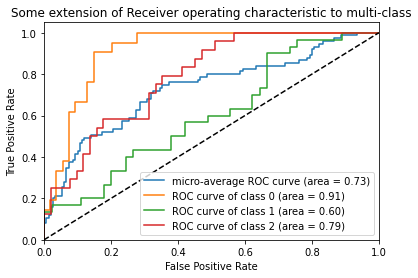

In [24]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]


# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [56]:
eval_data

,Unnamed: 0,docnum,tags,source,text,row_id,paper1_cord_uid,paper2_cord_uid,text1,text2,annotation,simple_tags,BioBERT_Prediction_con,BioBERT_Prediction_ent,BioBERT_Prediction_neu,label,BioBERT_Prediction_class
0,128,128,CONTRADICTION,Demo-Annotations_43573ac3-R1,Claim1:\n\nsecondary clinical outcomes were al...,392,zhfrgaxf,2txzi7kb,secondary clinical outcomes were also consider...,three studies reported no significant differen...,contradiction,CONTRADICTION,0.999830,0.000031,0.000139,contradiction,contradiction
1,605,605,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nthe clinical use of tocilizumab can...,971,nqprluto,e5hi63rm,the clinical use of tocilizumab can be referre...,the mortality rate over a 30-days observation ...,neutral,NEUTRAL,0.000782,0.000485,0.998734,neutral,neutral
2,58,58,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\ncandidate drugs for post-exposure p...,513,n0mz098o,k50qvr4w,candidate drugs for post-exposure prophylaxis ...,-there is the necessity to quickly find therap...,neutral,NEUTRAL,0.000042,0.982423,0.017534,neutral,entailment
3,577,577,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nonly in one patient was treatment s...,574,rqjzl8js,mzon01fd,"only in one patient was treatment stopped, due...","in fact, in portugal, hydroxychloroquine is ap...",neutral,NEUTRAL,0.004609,0.659957,0.335435,neutral,entailment
4,384,384,NEUTRAL,Demo-Annotations_43573ac3-R1,"Claim1:\n\namong the studied comorbidities, di...",377,7hnh85wy,be8eu3qi,"among the studied comorbidities, diabetes, pur...",further studies need to be conducted on a larg...,neutral,NEUTRAL,0.000007,0.018491,0.981502,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,791,791,NEUTRAL,Demo-Annotations_43573ac3-R1,"Claim1:\n\nhowever, prospective clinical studi...",934,dk1rk908,rpmmadqc,"however, prospective clinical studies are requ...",this retrospective observational study is to o...,neutral,NEUTRAL,0.029673,0.110376,0.859951,neutral,neutral
496,632,632,ENTAILMENT,Demo-Annotations_43573ac3-R1,Claim1:\n\narabi and colleagues initiated a pl...,739,0nhgxoim,gh51ag2x,arabi and colleagues initiated a placebo-contr...,"in addition, considering that this unique trea...",entailment,ENTAILMENT,0.001655,0.006200,0.992145,entailment,neutral
497,636,636,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nall 50 (100%) patients received ant...,970,aidsz3st,n0mz098o,all 50 (100%) patients received antiviral ther...,besides preventive strategies against sars-cov...,neutral,NEUTRAL,0.000075,0.037961,0.961965,neutral,neutral
498,583,583,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\ngiven its questionable efficacy in ...,510,hasoaa0k,aidsz3st,given its questionable efficacy in the treatme...,all 50 (100%) patients received antiviral ther...,neutral,NEUTRAL,0.000187,0.006386,0.993426,neutral,neutral


<ipython-input-71-6e706962984e>:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


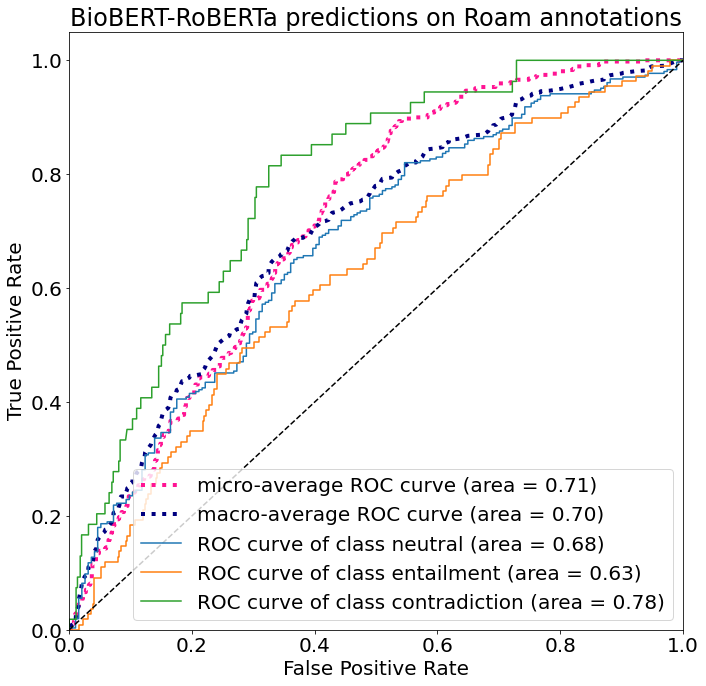

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

rcParams['figure.figsize'] = 11, 11
plt.rcParams.update({'font.size': 20})

# Binarize the annotations
n_classes = 3
#binarized_annotations = label_binarize(eval_data.annotation, classes=["contradiction", "entailment", "neutral"])
binarized_annotations = label_binarize(eval_data.annotation, classes=["neutral", "entailment", "contradiction"])
predicted_annotations = predictions

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_annotations[:, i], predicted_annotations[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_annotations.ravel(), predicted_annotations.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

classes=["neutral", "entailment", "contradiction"]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BioBERT-RoBERTa predictions on Roam annotations')
plt.legend(loc="lower right")
plt.show()

In [75]:
predictions

array([[1.3920339e-04, 3.1120133e-05, 9.9982965e-01],
       [9.9873382e-01, 4.8453960e-04, 7.8156550e-04],
       [1.7534122e-02, 9.8242342e-01, 4.2477332e-05],
       ...,
       [9.6196455e-01, 3.7960853e-02, 7.4529635e-05],
       [9.9342620e-01, 6.3862819e-03, 1.8749249e-04],
       [3.0401358e-04, 4.9663842e-05, 9.9964631e-01]], dtype=float32)

<ipython-input-106-2aa36866dcf6>:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-106-2aa36866dcf6>:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr_tb[i], tpr_tb[i])
<ipython-input-106-2aa36866dcf6>:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


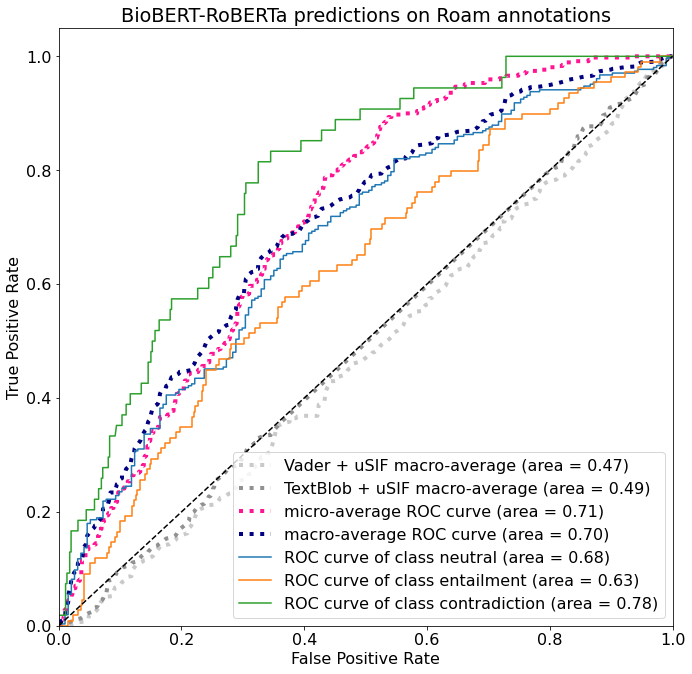

In [106]:
# ROC of that benchmark

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

rcParams['figure.figsize'] = 11, 11
plt.rcParams.update({'font.size': 16})

# Binarize the annotations
n_classes = 3
#binarized_annotations = label_binarize(eval_data.annotation, classes=["contradiction", "entailment", "neutral"])
binarized_annotations = label_binarize(eval_data.annotation, classes=["neutral", "entailment", "contradiction"])
predicted_annotations = eval_data.vader_sim_score.values

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_annotations[:, i], predicted_annotations)
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(binarized_annotations.ravel(), predicted_annotations.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='Vader + uSIF macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='#c9c9c9', linestyle=':', linewidth=4)

classes=["neutral", "entailment", "contradiction"]
#for i in range(n_classes):
#    plt.plot(fpr[i], tpr[i], label='Vader + uSIF -- {0} (area = {1:0.2f})'
#                                   ''.format(classes[i], roc_auc[i]), color="#c9c9c9")
    
    
    

# EXTREMELY JANKY COPY PASTE. DON"T DO THIS



predicted_annotations_tb = eval_data.tb_sim_score.values


fpr_tb = dict()
tpr_tb = dict()
roc_auc_tb = dict()
for i in range(n_classes):
    fpr_tb[i], tpr_tb[i], _ = roc_curve(binarized_annotations[:, i], predicted_annotations_tb)
    roc_auc_tb[i] = auc(fpr_tb[i], tpr_tb[i])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr_tb[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr_tb[i], tpr_tb[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr_tb["macro"] = all_fpr
tpr_tb["macro"] = mean_tpr
roc_auc_tb["macro"] = auc(fpr_tb["macro"], tpr_tb["macro"])
##plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_tb["macro"], tpr_tb["macro"],
         label='TextBlob + uSIF macro-average (area = {0:0.2f})'
               ''.format(roc_auc_tb["macro"]),
         color='#919191', linestyle=':', linewidth=4)

classes=["neutral", "entailment", "contradiction"]
#for i in range(n_classes):
#    plt.plot(fpr_tb[i], tpr_tb[i], label='TextBlob + uSIF -- {0} (area = {1:0.2f})'
#                                   ''.format(classes[i], roc_auc_tb[i]), color='#919191')
    
    
    
    
# Real model
predicted_annotations = predictions

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_annotations[:, i], predicted_annotations[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_annotations.ravel(), predicted_annotations.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
##plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

classes=["neutral", "entailment", "contradiction"]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))   

    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BioBERT-RoBERTa predictions on Roam annotations')
plt.legend(loc="lower right")
plt.show()

In [18]:
print(eval_data.text1[0])
print()
print(eval_data.text2[0])

secondary clinical outcomes were also considered key benefits as they refer to anticipated clinical endpoints as a result of chloroquine or hydroxychloroquine treatment, which reflect potential reductions in disease progression, such as development of pneumonia or acute respiratory distress syndrome (ards).

three studies reported no significant difference in the risk of pneumonia between chloroquine and controls.


In [33]:
eval_data.head(3)

,Unnamed: 0,docnum,tags,source,text,row_id,paper1_cord_uid,paper2_cord_uid,text1,text2,annotation,simple_tags,BioBERT_Prediction_con,BioBERT_Prediction_ent,BioBERT_Prediction_neu,label,BioBERT_Prediction_class
0,128,128,CONTRADICTION,Demo-Annotations_43573ac3-R1,Claim1:\n\nsecondary clinical outcomes were al...,392,zhfrgaxf,2txzi7kb,secondary clinical outcomes were also consider...,three studies reported no significant differen...,contradiction,CONTRADICTION,0.999830,0.000031,0.000139,contradiction,contradiction
1,605,605,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\nthe clinical use of tocilizumab can...,971,nqprluto,e5hi63rm,the clinical use of tocilizumab can be referre...,the mortality rate over a 30-days observation ...,neutral,NEUTRAL,0.000782,0.000485,0.998734,neutral,neutral
2,58,58,NEUTRAL,Demo-Annotations_43573ac3-R1,Claim1:\n\ncandidate drugs for post-exposure p...,513,n0mz098o,k50qvr4w,candidate drugs for post-exposure prophylaxis ...,-there is the necessity to quickly find therap...,neutral,NEUTRAL,0.000042,0.982423,0.017534,neutral,entailment


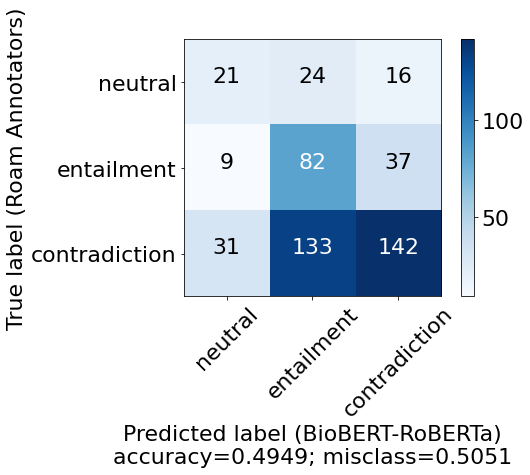

In [47]:
# BioBERT confusion matrix:

#print(len(eval_data[eval_data.vader_call == eval_data.simple_tags]))
#print(len(eval_data[eval_data.tb_call == eval_data.simple_tags]))

from pylab import rcParams

rcParams['figure.figsize'] = 40, 40
plt.rcParams.update({'font.size': 22})

eval_data_no_na = eval_data[eval_data.simple_tags != "N/A"]

cm = confusion_matrix(eval_data_no_na.simple_tags.str.lower(), eval_data_no_na.BioBERT_Prediction_class)
#sklearn.metrics.confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import itertools

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

cmap = None
if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
#plt.title("Confusion Matrix")
plt.colorbar()

target_names = ["neutral", "entailment", "contradiction"]
if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

normalize = False
thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, f"{cm[i,j]:0.4f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label (Roam Annotators)')
plt.xlabel(f"Predicted label (BioBERT-RoBERTa)\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")
plt.show()

# TO DO: WHERE ARE NEUTRALS??? FIX THE NAAMES OF THE LABELS 

In [117]:
print(eval_data.columns)
con_ent = eval_data[(eval_data["BioBERT_Prediction_class"] == "entailment") & (eval_data["annotation"] == "contradiction")]
con_neu = eval_data[(eval_data["BioBERT_Prediction_class"] == "neutral") & (eval_data["annotation"] == "contradiction")]
ent_con = eval_data[(eval_data["BioBERT_Prediction_class"] == "contradiction") & (eval_data["annotation"] == "entailment")]

#eval_data.BioBERT_Prediction_class
#eval_data.annotation

Index(['Unnamed: 0', 'docnum', 'tags', 'source', 'text', 'row_id',
       'paper1_cord_uid', 'paper2_cord_uid', 'text1', 'text2', 'annotation',
       'simple_tags', 'BioBERT_Prediction_con', 'BioBERT_Prediction_ent',
       'BioBERT_Prediction_neu', 'label', 'BioBERT_Prediction_class',
       'vader_pol_1', 'vader_pol_2', 'tb_pol_1', 'tb_pol_2', 'vader_call',
       'tb_call', 'uSIF_sims', 'vader_call_num', 'tb_call_num',
       'vader_sim_score', 'tb_sim_score'],
      dtype='object')


In [118]:
con_ent.to_csv("/Users/dnsosa/Desktop/tmp_examples/con_ent.csv")
con_neu.to_csv("/Users/dnsosa/Desktop/tmp_examples/con_neu.csv")
ent_con.to_csv("/Users/dnsosa/Desktop/tmp_examples/ent_con.csv")

In [8]:
# Report top-scoring contradictions

k = 3

def print_pair(claim1, claim2, score):
    print("\nClaim 1")
    print(claim1)
    print("\nClaim 2")
    print(claim2)
    print(f"\nScore: {score:.3f}")
    print("------------")
    

# TODO: Do this on all data

print(f"The top {k} most contradictory pairs are as follows:")
print("===================================================")
eval_data_top_con = eval_data.sort_values(by='BioBERT_Prediction_con', ascending=False).head(k)
for i in range(k):
    pair_i = eval_data_top_con.iloc[i]
    print_pair(pair_i.text1, pair_i.text2, pair_i.BioBERT_Prediction_con)
print("\n\n")
    
print(f"The top {k} most entailing pairs are as follows:")
print("=================================================")
eval_data_top_ent = eval_data.sort_values(by='BioBERT_Prediction_ent', ascending=False).head(k)
for i in range(k):
    pair_i = eval_data_top_ent.iloc[i]
    print_pair(pair_i.text1, pair_i.text2, pair_i.BioBERT_Prediction_ent)
print("\n\n")
    
print(f"The top {k} most neutral pairs are as follows:")
print("===============================================")
eval_data_top_neu = eval_data.sort_values(by='BioBERT_Prediction_neu', ascending=False).head(k)
for i in range(k):
    pair_i = eval_data_top_neu.iloc[i]
    print_pair(pair_i.text1, pair_i.text2, pair_i.BioBERT_Prediction_neu)
print("\n\n")


The top 3 most contradictory pairs are as follows:

Claim 1
given its questionable efficacy in the treatment of covid-19 and its risk of qt-prolongation, chloroquine treatment must be considered thoroughly, and reviewed on a regular basis.

Claim 2
besides preventive strategies against sars-cov-2 infection practiced in many countries, such as quarantine of confirmed infected individuals, contact tracing by smartphone, protection of individuals at high risk of infection, nationwide limited curfew, and the urgent development and rapid provision of a vaccine, the who and the european union recently and urgently initiated clinical trials to test remdesivir, chloroquine and hydroxychloroquine, lopinavir/ritonavir, and lopinavir/ritonavir plus interferon  -1a in covid-19 patients worldwide in the solidarity trial [141] and in the discovery trial [91].

Score: 1.000
------------

Claim 1
among the studied comorbidities, diabetes, pure hypercholesterolemia, asthma, copd, chronic kidney disease

<AxesSubplot:xlabel='BioBERT_Prediction_neu'>

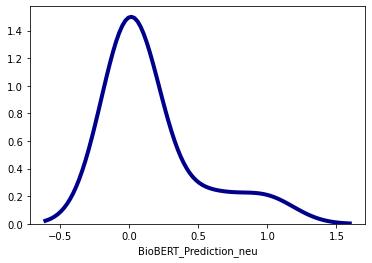

In [92]:
# Report most "found" contradictions by drug mention.

query_drug = "chloroquine"
drug_eval_data = eval_data[eval_data.evaluated_for == query_drug]
#drug_contras_distribution = drug_eval_data.BioBERT_Prediction_neu

import seaborn as sns

# sns.distplot(drug_eval_data.BioBERT_Prediction_neu, hist=True, kde=True, 
#              bins=10, color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

sns.distplot(drug_eval_data.BioBERT_Prediction_neu, hist=False, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Qualitative Evaluation
We will now qualitatively look at a few examples.

In [ ]:
output_data = pd.read_excel('/kaggle/input/drug-individual-claims-similarity-annotated/drug_individual_claims_similarity_annotated.xlsx',sheet_name='drug_individual_claims_similari')
output_data = output_data.dropna().reset_index(drop=True)

In [ ]:
ls = []
for i in range(len(output_data)):
    ls.append(str('[CLS]'+output_data.loc[i,'text1']+'[SEP]'+output_data.loc[i,'text2']))
    
test_example = regular_encode(ls, tokenizer, maxlen=MAX_LEN)
predictions = model.predict(test_example)
if method=='1':
    output_data['BioBERT_Prediction'] = [p[0] for p in predictions]
if method=='2':
    output_data['BioBERT_Prediction_con'] = [p[0] for p in predictions]
    output_data['BioBERT_Prediction_ent'] = [p[1] for p in predictions]
    output_data['BioBERT_Prediction_neu'] = [p[2] for p in predictions]

In [ ]:
print(len(output_data))
print(len(output_data.loc[output_data.annotation=='contradiction',:]))
print(len(output_data.loc[output_data.annotation=='entailment',:]))
print(len(output_data.loc[output_data.annotation=='neutral',:]))

In [ ]:
if method=='1':
    print(max(output_data.BioBERT_Prediction))
if method=='2':
    print(max(output_data.BioBERT_Prediction_con))
    print(max(output_data.BioBERT_Prediction_ent))
    print(max(output_data.BioBERT_Prediction_neu))

In [ ]:
if method=='1':
    output_data['label'] = [1 if a=='contradiction' else 0 for a in output_data.annotation]
    output_data['BioBERT_Prediction_class'] = [1 if p>=0.375 else 0 for p in output_data.BioBERT_Prediction]
    
    print('Overall accuracy: '\
      + str(accuracy_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('Recall: '\
          + str(recall_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('F1 score: '\
          + str(f1_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))

if method=='2':
    output_data['label'] = output_data.annotation
    output_data['BioBERT_Prediction_class'] = output_data[['BioBERT_Prediction_con','BioBERT_Prediction_ent','BioBERT_Prediction_neu']].idxmax(axis=1)
    output_data['BioBERT_Prediction_class'].replace(to_replace={'BioBERT_Prediction_con':'contradiction','BioBERT_Prediction_ent':'entailment','BioBERT_Prediction_neu':'neutral'}\
                                                   ,inplace=True)
    
    print('Overall accuracy: '\
      + str(accuracy_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(output_data['label'], output_data['BioBERT_Prediction_class'], average = None)))
    print('Recall: '\
          + str(recall_score(output_data['label'], output_data['BioBERT_Prediction_class'], average = None)))
    print('F1 score: '\
          + str(f1_score(output_data['label'], output_data['BioBERT_Prediction_class'], average = None)))

In [ ]:
output_data.to_csv('bioBERT_Output.csv',header=True)